## Massively parallel phage display panning against _P. aeruginosa_ cells, extended panning (`fig-panning-massive`)

Note: the other portions of this figure are generated in the notebooks for `panning-massive`: [fig-panning-massive](../../../panning-massive/workflow/notebooks/fig-panning-massive.ipynb)

In [1]:
import os

# change working directory to `./panning-massive` for simplicity of access to feature tables, etc
# make sure we don't do this twice, or we'll end up in the wrong place and be very confused
if 'dir_changed' not in globals():
    os.chdir('../../')
    dir_changed = True

In [2]:
import pandas as pd, numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import plotnine
from plotnine import *

In [3]:
import nbseq
import nbseq.ft
import nbseq.viz.asv
import nbseq.viz.sample
from nbseq.viz.utils import extract_encoded_data_plotnine

In [4]:
plt.rcParams.update({
    "font.family":"sans",
    'font.size': 6})

FONT_SIZE = 5

In [5]:
%config InlineBackend.figure_formats = ['svg']

***

In [6]:
ex = nbseq.Experiment.from_files(
    metadata='config/metadata_full.csv',
    ft_aa=None,
    tree_cdr3=None, tree_aa=None
    ) #'intermediate/cdr3/features/all/alpaca/asvs.nwk')
ex.obs['OprOP'] = np.nan

Loading experiment panning-extended from '/vast/palmer/home.mccleary/cng2/code/phageseq-paper/panning-extended'...
- Reading metadata from config/metadata_full.csv ...
- Reading phenotypes from config/phenotypes.csv ...
- Reading Config from config/config.yaml ...
- Using SQL database at 'sqlite:////vast/palmer/home.mccleary/cng2/code/phageseq-paper/panning-extended/intermediate/aa/asvs.db'
- Reading feature data for table 'cdr3' from results/tables/cdr3/asvs.csv (2.6 MB)...
- Reading cdr3 feature table from results/tables/cdr3/feature_table.biom (8.4 MB)...
- Warning: mmseqs2 database for space 'aa' at 'intermediate/aa/features_db/features' does not exist!
- Using mmseqs2 database 'cdr3' at 'intermediate/cdr3/features_db/features'
- Reading enrichment model (conditional ECDF) for space cdr3 from results/tables/cdr3/enrichment/null/ecdf.pickle (307.6 kB)...
Finished in 0.28 seconds


In [7]:
ex

Experiment('panning-extended') with feature spaces ['cdr3']:
  obs: ['plate.x' 'well.x' 'depth' 'expt' 'round' 'sample' 'phage_library'
    'notes' 'r' 'io' 'kind' 'selection' 'replicate' 'name_full' 'name'
    'well_027e' 'sel_plate_027i' 'sel_well_027i' 'selection_027j' 'plate.y'
    'well.y' 'category' 'antigen' 'genotype_pair' 'gene_CS' 'gene_S'
    'genotype_CS' 'background_CS' 'strain_CS' 'loc_CS' 'cond_CS' 'genotype_S'
    'background_S' 'strain_S' 'loc_S' 'cond_S' 'cond_notes' 'bflm' 'swim'
    'twitch' 'swarm' 'PMB-R' 'FEP-R' 'TET-R' 'CIP-R' 'CHL-R' 'GEN-R' 'ERY-R'
    'IPM-R' 'cdiGMP' 'FliC' 'FliCa' 'FliCb' 'FlgEHKL' 'PilQ' 'PilA' 'PilB'
    'LasA' 'LasB' 'Apr' 'XcpQ' 'ToxA' 'EstA' 'LepA' 'PlpD' 'Phz' 'Pcn' 'Pvd'
    'Hcn' 'Rhl' 'T3SS' 'T6SS' 'Pel' 'Psl' 'CdrB' 'SCV' 'Mucoid' 'Alginate'
    'OprM' 'OprJ' 'OprN' 'OprOP' 'OpdH' 'OprD' 'OprL' 'OprF' 'OprG' 'OprH'
    'OprB' 'MexAB' 'MexCD' 'MexEF' 'MexJK' 'MexXY' 'MexGHI' 'PirA' 'Pfu'  'TonB'
    'FptA' 'FpvA' 'PfeA' 'CupB5' 'Cu

In [8]:
from nbseq.viz.utils import shorten_descriptions
import re
replacements = {
    re.compile(r"(\w+)\#[^\s:]+"): r"\1",
    "ZTP riboswitch":"...",
    "PAO397":"PAO1",
}
    

shorten_descriptions(ex.obs, replacements=replacements);
shorten_descriptions(ex.fts.cdr3.obs, replacements=replacements);
ex.fts.cdr3.obs['desc_short_ml'] = ex.fts.cdr3.obs['desc_short'].str.replace("/","\n")

shorten_descriptions(ex.obs);
shorten_descriptions(ex.fts.cdr3.obs);

## Barplots

In [9]:
def top_asv_barplot(ex, query, space='cdr3', n=30, select_from_round=8, phylo=False, **kwargs):
    samples = ex.query_ids(f"({query}) & kind =='+' & io == 'i'", space=space)
    if select_from_round is not None:
        top_from_samples = ex.query_ids(f"({query}) & r == {select_from_round} & kind =='+' & io == 'i'", space=space)
    else:
        top_from_samples = None
    
    
    ft_top = nbseq.viz.sample.collapse_top_asvs(ex.fts[space], samples, top_from_samples = top_from_samples, n=n)
    df = nbseq.ft.fortify(ft_top, obs=True, relative=True)
    
    if phylo:
        return nbseq.viz.sample.top_asv_plot_phylo(df, ex.tree[space], **kwargs)
    else: 
        return nbseq.viz.sample.top_asv_barplot(df, feature_name=space.upper(), **kwargs)

def cleanup_source_data(df):
    df['desc_short_ml'] = df['desc_short_ml'].str.replace('\n',' vs. ')
    df.rename(columns={'desc_short_ml':'selection condition'}, inplace=True)
    return df

In [10]:
layers = [
    theme_bw(), 
    theme(
        legend_key_height=4,
        legend_key_width=4,
        text=element_text(family='sans', size=5)
    )
]

def make_barplot(query, name, extra_layers = []):
    gg = (
    top_asv_barplot(ex, 
                     query, 
                     facet={'facets':"selection+'\\n'+desc_short_ml", 'ncol':3}, n=40) 
    )
    gg += layers
    gg += extra_layers
    # gg += theme(figure_size=(4,2))
    gg.save(f"results/plots/barplots/{name}.svg")
    df = cleanup_source_data(extract_encoded_data_plotnine(gg)).to_csv(f"results/tables/figures/barplots/{name}.csv", index=False)
    return gg

In [11]:
%%bash
mkdir -p results/plots/barplots
mkdir -p results/plots/rank_abundance
mkdir -p results/tables/figures/barplots
mkdir -p results/tables/figures/rank_abundance

/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 4 x 2 in image.
/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: results/plots/barplots/flhA_vs_fleN_fliC.svg


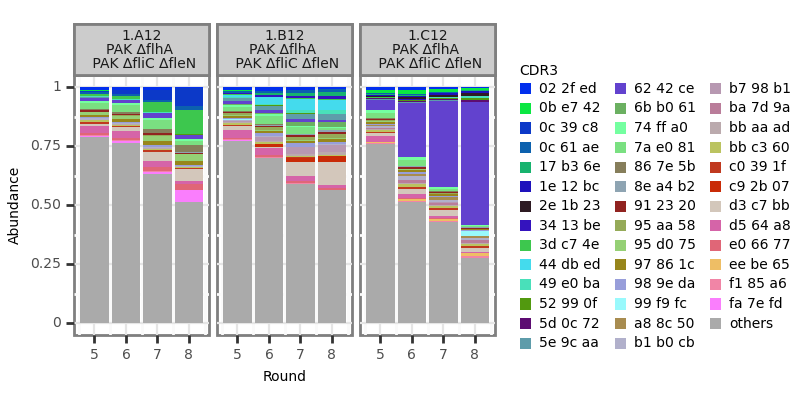

<Figure Size: (400 x 200)>

In [12]:
make_barplot(f"genotype_pair == 'flhA/fleN fliC' & (selection in['1.A12','1.B12','1.C12'])",
             "flhA_vs_fleN_fliC",
[theme(figure_size=(4,2))])

/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 4 x 4 in image.
/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: results/plots/barplots/efflux_vs_oprM.svg


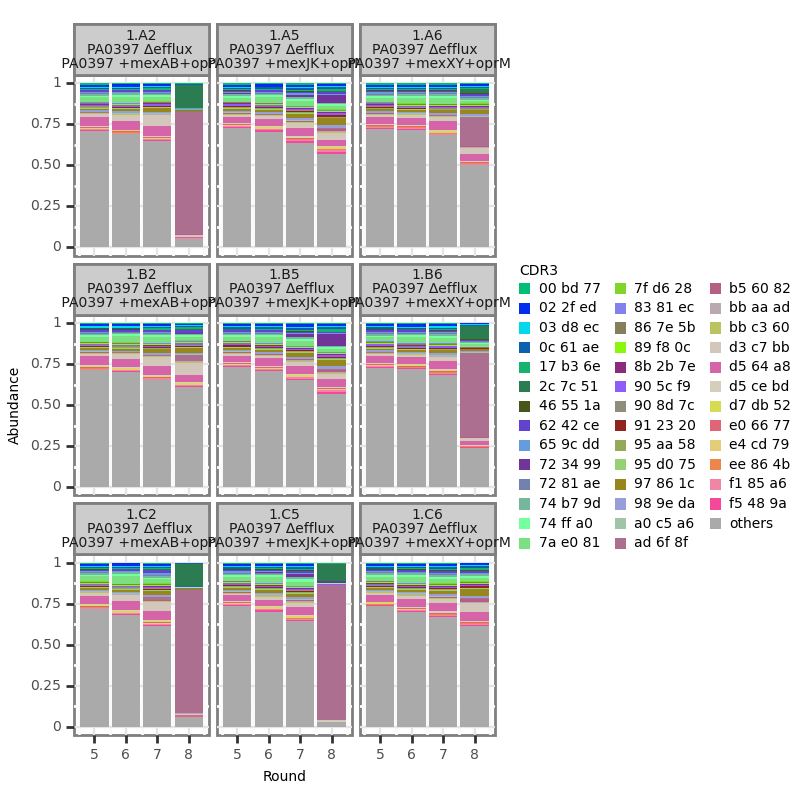

<Figure Size: (400 x 400)>

In [13]:
make_barplot(
    ("(selection in ['1.A2', '1.B2', '1.C2','1.A5', '1.B5', '1.C5','1.A6', '1.B6', '1.C6']) "
     "& (genotype_S == '+mexAB+oprM' | genotype_S == '+mexJK+oprM' | genotype_S == '+mexXY+oprM')"),
     "efflux_vs_oprM",
[theme(figure_size=(4,4))])

## Whittaker plots

In [14]:
import nbseq.viz.sample as nvs
import nbseq.viz.tree
import nbseq.ft as nbft
from nbseq.utils import replace_multiple

In [15]:
def whittaker(ex, library, space='cdr3', predicates='', **kwargs):
    query = f"replicate == 1 & io == 'i' & kind == '+'"
    if predicates != '':
        query += f" & ({predicates})"
    ft = ex.query(query, space=space)

    return nbseq.viz.sample.rank_abundance_plot(ft, **kwargs)

from matplotlib.ticker import EngFormatter

fmt = EngFormatter(sep="")
def order_facets(column, order):
    def _reorder(df):
        df[column] = df[column].astype("category").cat.reorder_categories(order)
        return df
    return _reorder

layers_whittaker = [
    scale_color_cmap("viridis"),
    scale_x_continuous(name="feature rank", labels=lambda x: list(map(fmt.format_eng, x))),
    facet_wrap("selection+'\\n'+desc_short_ml", ncol=3),
    theme_bw(), 
    theme(
        legend_key_height=4,
        legend_key_width=4,
        text=element_text(family='sans', size=5)
    ),
    guides(color=guide_legend(title="round"))
]

def make_whittaker(query, name, extra_layers = []):
    g = whittaker(ex, 'alpaca', 
              predicates=query,
              color="r", 
              n_sample=dict(n=20, replace=True),
              line=dict(size=1),
              group="r",
              # transform=order_facets("desc_ag_short", ["PAK flagellum", "PAO1 flagellum", "PAK pilus", "PA103 pilus"])
             )
    g += layers_whittaker
    g += theme(figure_size=(3,1.5))
    g += extra_layers
    g.save(f"results/plots/rank_abundance/{name}.svg")
    cleanup_source_data(extract_encoded_data_plotnine(g)).to_csv(f"results/tables/figures/rank_abundance/{name}.csv", index=False)
    return g

/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 3 x 1.5 in image.
/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: results/plots/rank_abundance/flhA_vs_fleN_fliC.svg


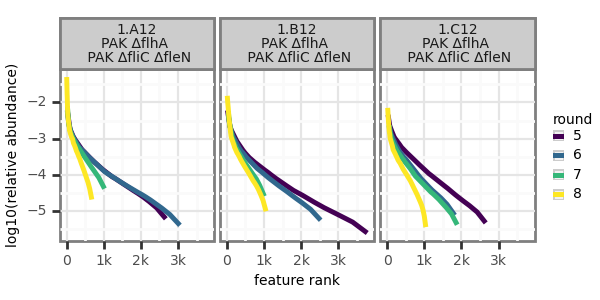

<Figure Size: (300 x 150)>

In [16]:
make_whittaker("(selection in ['1.A12','1.B12','1.C12'])", "flhA_vs_fleN_fliC")

/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 3 x 3 in image.
/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: results/plots/rank_abundance/efflux_vs_oprM.svg


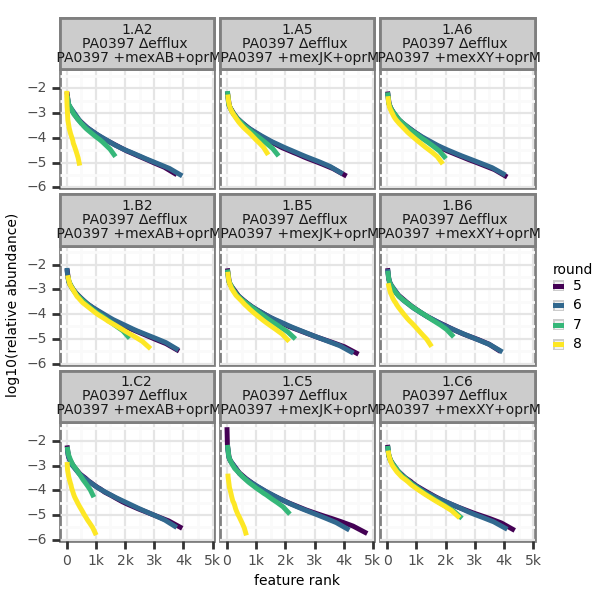

<Figure Size: (300 x 300)>

In [17]:
make_whittaker(
    ("(selection in ['1.A2', '1.B2', '1.C2','1.A5', '1.B5', '1.C5','1.A6', '1.B6', '1.C6']) "
     "& (genotype_S == '+mexAB+oprM' | genotype_S == '+mexJK+oprM' | genotype_S == '+mexXY+oprM')"), 
    "efflux_vs_oprM", [theme(figure_size=(3,3))])

## Phenotype barplots

In [18]:
test_ags = ['FliC', 'FliCa', 'FliCb', 'FlgEHKL', 'PilQ', 'PilA', 'Pel', 'Psl', 'OprM', 'T3SS']

In [19]:
%%bash
mkdir -p results/plots/barplots_suppl/

In [20]:
from IPython.display import Markdown

ncol = 6
for antigen in ['FliC', 'FlgEHKL', 'PilQ', 'OprM', 'OprN', 'OprJ', 'T3SS']:#list(ex.ag_names)[0:5]:
# for antigen in test_ags:
    display(Markdown(f"#### {antigen}"))
    n_samples = ex.obs.query(f"`{antigen}` == 1")['selection'].nunique()

    gg = top_asv_barplot(ex, f"`{antigen}` == 1", facet={'facets':"selection+'\\n'+desc_short_ml", 'ncol':ncol}, n=100) 
    gg += theme_bw()
    gg += theme(
        figure_size=(10,max((n_samples//ncol),1)*4/3), 
        legend_key_height=4,
        legend_key_width=4,
        text=element_text(family='sans', size=5)
               )

    gg.save(f"results/plots/barplots_suppl/{antigen}.svg")

#### FliC

/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 10 x 1.3333333333333333 in image.
/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: results/plots/barplots_suppl/FliC.svg


#### FlgEHKL

/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 10 x 2.6666666666666665 in image.
/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: results/plots/barplots_suppl/FlgEHKL.svg


#### PilQ

/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 10 x 1.3333333333333333 in image.
/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: results/plots/barplots_suppl/PilQ.svg


#### OprM

/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 10 x 4.0 in image.
/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: results/plots/barplots_suppl/OprM.svg


#### OprN

/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 10 x 1.3333333333333333 in image.
/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: results/plots/barplots_suppl/OprN.svg


#### OprJ

/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 10 x 1.3333333333333333 in image.
/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: results/plots/barplots_suppl/OprJ.svg


#### T3SS

/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 10 x 2.6666666666666665 in image.
/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: results/plots/barplots_suppl/T3SS.svg
